<a href="https://colab.research.google.com/github/Avipsa1/UPPP275-Notebooks/blob/main/Exploratory_Spatial_Data_Analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating spatial weights matrix is an important aspect of examining spatial relationships across different spatial units or geometries. It defines how they're spatially connected to one another. These weights can take on many different forms. Based on our specific theoretical needs we can choose from the following:

* Rook contiguity
* Queen contiguity
* K-nearest neighbors
* Distance band

Using rook contiguity, two spatial units must share an edge of their boundaries to be considered neighbors. 



Let us install and import all necessary packages before we begin our analysis

In [ ]:
!pip install geopandas
!pip install pysal
!pip install seaborn

In [7]:
import pandas as pd
import geopandas as gpd
import pysal as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats

# load CA tracts, display shape
tracts_ca = gpd.read_file('tl_2017_06_tract.shp')
tracts_ca = tracts_ca.set_index('GEOID')
tracts_ca.shape

(8057, 12)

In [8]:
# retain LA county only (and drop channel island tracts)
tracts_ca = tracts_ca[tracts_ca['COUNTYFP']=='037'].drop(index=['06037599100', '06037599000'])
tracts_ca.shape

(2344, 12)

In [9]:
# project spatial geometries to a meter-based projection for SoCal
crs = '+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
tracts_ca = tracts_ca.to_crs(crs)

In [10]:
# load CA tract-level census variables
df_census = pd.read_csv('census_tracts_data_ca.csv', dtype={'GEOID10':str}).set_index('GEOID10')
df_census.shape

(8057, 27)

In [11]:
# merge tract geometries with census variables
tracts = tracts_ca.merge(df_census, left_index=True, right_index=True, how='left')
tracts.shape

(2344, 39)

In [12]:
# calculate pop density in persons per sq km
# turn any infinities into nulls
tracts['pop_density'] = tracts['total_pop'] / (tracts['ALAND'] / 1e6)
tracts = tracts.replace([np.inf, -np.inf], np.nan)

In [13]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,...,pct_below_poverty,pct_college_grad_student,pct_same_residence_year_ago,pct_bachelors_degree,pct_english_only,pct_foreign_born,state,county,county_name,pop_density
GEOID,,,,,,,,,,,,,,,,,,,,,
06037204920,06,037,204920,2049.20,Census Tract 2049.20,G5020,S,909972,0,+34.0175004,...,28.3,19.0,91.7,8.7,14.0,39.9,6,37,Los Angeles,2992.399766
06037205110,06,037,205110,2051.10,Census Tract 2051.10,G5020,S,286962,0,+34.0245059,...,29.4,20.9,90.8,5.9,6.5,53.1,6,37,Los Angeles,13646.406144
06037205120,06,037,205120,2051.20,Census Tract 2051.20,G5020,S,1466129,0,+34.0187546,...,35.5,23.2,91.2,4.8,10.4,47.9,6,37,Los Angeles,2338.129864
06037206010,06,037,206010,2060.10,Census Tract 2060.10,G5020,S,1418138,20551,+34.0682177,...,38.7,21.4,94.0,13.6,22.3,49.4,6,37,Los Angeles,2528.667873
06037206020,06,037,206020,2060.20,Census Tract 2060.20,G5020,S,843243,30290,+34.0571230,...,15.2,52.9,41.2,7.3,60.8,11.1,6,37,Los Angeles,9624.746366


In [14]:
tracts.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'total_pop', 'median_age', 'pct_hispanic', 'pct_white', 'pct_black',
       'pct_asian', 'pct_male', 'pct_single_family_home', 'med_home_value',
       'med_rooms_per_home', 'pct_built_before_1940', 'pct_renting',
       'rental_vacancy_rate', 'avg_renter_household_size', 'med_gross_rent',
       'med_household_income', 'mean_commute_time', 'pct_commute_drive_alone',
       'pct_below_poverty', 'pct_college_grad_student',
       'pct_same_residence_year_ago', 'pct_bachelors_degree',
       'pct_english_only', 'pct_foreign_born', 'state', 'county',
       'county_name', 'pop_density'],
      dtype='object')

Now lets calculate the rook contiguity matrix from the data

In [15]:
# get the tract labels (GEOIDs) and pick one (arbitrarily) to work with throughout
labels = tracts.index.tolist()
label = labels[210]
label

'06037900703'

In [33]:
%%time
import libpysal 
# calculate rook spatial weights
w_rook = libpysal.weights.Rook.from_dataframe(tracts, ids=labels, id_order=labels)

CPU times: user 2.44 s, sys: 133 ms, total: 2.58 s
Wall time: 2.6 s


In [34]:
# find the neighbors of some tract
# this is a raw contiguity matrix, so weights are binary 1s and 0s meaning neighbor/not
w_rook[label]

{'06037900701': 1.0,
 '06037900705': 1.0,
 '06037900805': 1.0,
 '06037901009': 1.0}

In [43]:
w_rook.cardinalities['06037900701']

4

In [44]:
w_rook.cardinalities['06037900705']

5

Using queen contiguity, two spatial units need only share a vertex (a single point) of their boundaries to be considered neighbors.

In [35]:
%%time
# calculate queen spatial weights
w_queen = libpysal.weights.Queen.from_dataframe(tracts, ids=labels, id_order=labels)

CPU times: user 3.7 s, sys: 90 ms, total: 3.79 s
Wall time: 4.38 s


In [36]:
# find the neighbors of some tract
# this is a raw contiguity matrix, so weights are binary 1s and 0s meaning neighbor/not
w_queen[label]

{'06037900701': 1.0,
 '06037900704': 1.0,
 '06037900705': 1.0,
 '06037900805': 1.0,
 '06037900806': 1.0,
 '06037901008': 1.0,
 '06037901009': 1.0,
 '06037901011': 1.0}

In [46]:
# how many neighbors does this tract have?
w_queen.cardinalities['06037900701']

8

In [47]:
w_queen.cardinalities['06037900704']

8

In [48]:
# convert cardinalities to series and describe data
pd.Series(w_queen.cardinalities).describe()

count    2344.000000
mean        6.468430
std         1.858143
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        33.000000
dtype: float64

In [49]:
# min number of neighbors
w_queen.min_neighbors

2

In [50]:
# max number of neighbors
w_queen.max_neighbors

33

In [51]:
# islands are observations with no neighbors, disconnected in space (can cause modeling problems)
w_queen.islands

[]

Plot a census tract of interest, along with its neighbors:

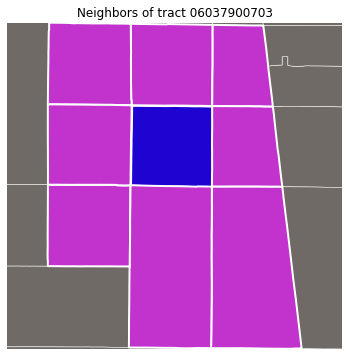

In [69]:
fig, ax = plt.subplots(figsize=(6, 6))
tracts.plot(ax=ax, facecolor='#6f6a66', edgecolor='w', linewidth=0.5)

# plot some tract of interest in blue
tract = tracts.loc[[label]]
tract.plot(ax=ax, facecolor='#1f03d0', edgecolor='w', linewidth=2)

# plot the neighbors in pink
neighbors = tracts.loc[w_queen[label]]
neighbors.plot(ax=ax, facecolor='#c133cc', edgecolor='w', linewidth=2)

# zoom to area of interest
xmin, ymin, xmax, ymax = neighbors.unary_union.bounds
ax.axis('equal')
ax.set_xlim(xmin-100, xmax+100)  # +/- 100 meters
ax.set_ylim(ymin, ymax)

ax.set_title('Neighbors of tract {}'.format(label))
_ = ax.axis('off')

CPU times: user 17.1 s, sys: 247 ms, total: 17.4 s
Wall time: 17.3 s


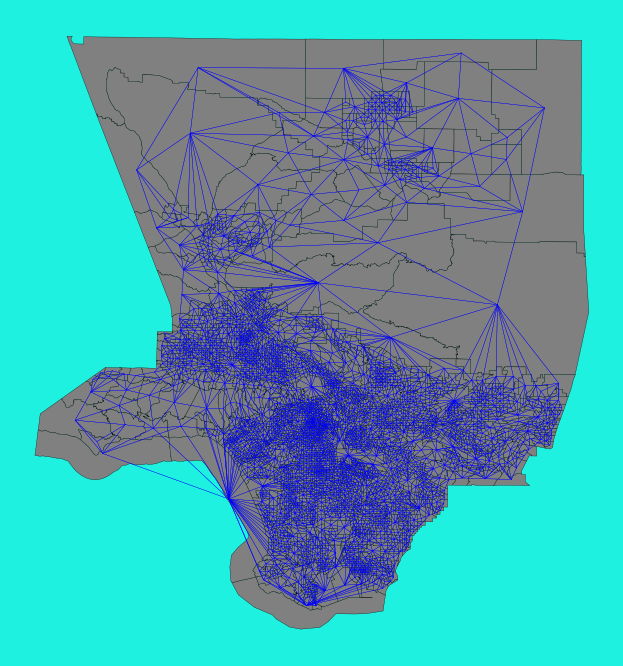

In [74]:
%%time
# draw a queen-contiguity graph of the tracts
fig, ax = plt.subplots(figsize=(12, 12), facecolor='#1ff1e1')
tracts.plot(ax=ax, facecolor='gray', edgecolor='k', linewidth=0.3)

# extract centroids of tract and its neighbors, then draw lines between them
for tract, neighbors in w_queen:
    tract_centroid = tracts.loc[tract, 'geometry'].centroid
    for neighbor_centroid in tracts.loc[neighbors, 'geometry'].centroid:
        Xs = [tract_centroid.x, neighbor_centroid.x]
        Ys = [tract_centroid.y, neighbor_centroid.y]
        ax.plot(Xs, Ys, color='b', linewidth=0.3)
_ = ax.axis('off')

Find the k-nearest neighbors of each tract, by centroid.

In [56]:
%%time
# k-nearest neighbors finds the closest k tract centroids to each tract centroid
w_knn = libpysal.weights.KNN.from_dataframe(tracts, k=6)

CPU times: user 628 ms, sys: 4.48 ms, total: 632 ms
Wall time: 798 ms


In [57]:
# they all have exactly k neighbors
w_knn.neighbors[label]

['06037900701',
 '06037900805',
 '06037901009',
 '06037900806',
 '06037901011',
 '06037901008']

For distance-band contiguity matrix, other tracts are considered neighbors of some tract if they are within a given threshold distance from the centroid of one tract. Distance band weights can be specified to take on continuous values rather than binary (1s and 0s), with these values being the inverse distance between each pair of "neighboring" units.

There are two ways to define distance decay:

* linear distance-decay exponent is -1 : 1/d
* gravity model distance-decay exponent is -2 : 1/d^2

In [59]:
# calculate maximum nearest neighbor distance so each unit is assured of >=1 neighbor
x = tracts.centroid.x
y = tracts.centroid.y
coords = np.array([x, y]).T
threshold = libpysal.weights.min_threshold_distance(coords)
threshold

15691.580020832942

In [61]:
%%time
# calculate linear decay continuous weights
w_dist = libpysal.weights.distance.DistanceBand.from_dataframe(tracts,
                                                             threshold=threshold,
                                                             binary=False,
                                                             alpha=-1)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/data.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


CPU times: user 3.95 s, sys: 381 ms, total: 4.33 s
Wall time: 5.01 s


In [62]:
# how many distance-band neighbors does our tract have?
len(w_dist.neighbors[label])

57

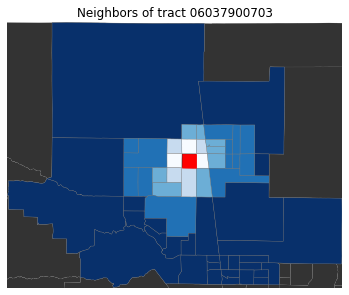

In [63]:
# map the neighbors, colored by weight from nearest to furthest
fig, ax = plt.subplots(figsize=(6, 6))
tracts.plot(ax=ax, facecolor='#333333', edgecolor='gray', linewidth=0.1)

# get the tract of interest and its neighbors/weights
tract = tracts.loc[[label]]
weights = pd.Series(w_dist[label])
neighbors = tracts.loc[weights.index, ['geometry']]
neighbors['weights_scaled'] = weights

# plot the tract's neighbors in blues by weight
neighbors.plot(ax=ax,
               column='weights_scaled',
               cmap='Blues_r',
               edgecolor='gray',
               linewidth=0.3,
               scheme='NaturalBreaks')

# plot the tract of interest in red
tract.plot(ax=ax, facecolor='r', edgecolor='r', linewidth=0.1)

# zoom to area of interest
xmin, ymin, xmax, ymax = neighbors.unary_union.bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title('Neighbors of tract {}'.format(label))
_ = ax.axis('off')

## Now it's your turn
* Recompute the distance-based spatial weights with a gravity decay
* Try to think and describe how and why this impacts the number of neighbors and the map above? 
